# WLS - Code Examples Part 3

just some notes:

Example 1. Non-Linear Example with Y-axis Errors with Negligible Standard Deviation for the First Point

Here we assume that the Y-value for x=0 should be equal to 100, so the error for this y data point is close to zero. For the remaining points, we expect errors to be the same and equal to 0.5. Thus, standard deviation is $\sigma_{i} = 0.5$ for each data point except the first one.

We set `sigma` array as `[1e-9, 0.5, 0.5, 0.5, ...]`. The first point with `sigma = 1e-9` gets an extremely large weight, forcing the fitted curve to pass almost exactly through that point. This value is chosen to be practically zero, thereby assigning an exceptionally large weight to this data point in the minimization process, compelling the fitted curve to pass almost exactly through $(x_1, y_1)$.

Based on the results, we will see why it was a bad idea to set negligible value of the standard deviation for the first point.

## Example 1. Non-Linear Example with Y-axis Errors

`sigma` array is `[0.5, 0.5, 0.5, 0.5, ...]` for all the data points.

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns
import scipy.stats as stats


In [41]:
def custom_function(x, A, B):
    """
    The custom function to approximate the data.
    f(x; A, B) = A * (np.exp(-B * x) - 1) + 100
    """
    return A * (np.exp(-B * x) - 1) + 100

In [42]:
# Initial guess for parameters A and B
initial_guess = [50, 0.01]

In [43]:
x = np.array([0, 5, 25, 34, 42, 57, 97])
y_obs = np.array([100, 79.7, 51.3, 44.6, 39.8, 29.9, 10.3])

# Define sigma for Weighted Least Squares
sigma = np.full_like(y_obs, 0.5, dtype=float)

weights = 1.0 / (sigma**2)

results = {}

results['x_data'] = x
results['y_data'] = y_obs
results['sigma'] = sigma
results['weights'] = weights

# # Dataset 2
# x = np.array([0, 19, 45, 104, 191, 294, 391])
# y_obs = np.array([100, 80.4, 66.4, 50.1, 41.2, 28.5, 20.1])

# # Dataset 3
# x = np.array([0, 23, 51, 98, 196, 292, 401])
# y_obs = np.array([100, 87.8, 77, 65.7, 50.9, 46.5, 44.4])

In [44]:
# curve_fit returns:
# popt: Optimal values for the parameters so that the sum of the squared residuals is minimized.
# pcov: The estimated covariance of popt.
# Use sigma for weighted least squares
popt, pcov, infodict, _, _ = curve_fit(custom_function, x, y_obs, p0=initial_guess, sigma=sigma, absolute_sigma=True, full_output=True)

fit_a, fit_b = popt

# Standard errors are the sqrt of the diagonal of the covariance matrix
perr = np.sqrt(np.diag(pcov))
std_err_a, std_err_b = perr

n = len(x)  # Number of observations
p = len(popt) # Number of parameters
degrees_of_freedom = n - p # Degrees of Freedom

# Generate predicted y values using the fitted function
y_pred = custom_function(x, fit_a, fit_b)

residuals_calc = y_obs - y_pred

weighted_residuals = (y_obs - y_pred) / sigma

residuals_scipy = infodict['fvec']

results['fit_a'] = fit_a
results['fit_b'] = fit_b
results['std_err_a'] = std_err_a
results['std_err_b'] = std_err_b
results['number_of_observations'] = n
results['number_of_parameters'] = p
results['degrees_of_freedom'] = degrees_of_freedom
results['y_pred'] = y_pred
results['residuals_calc'] = residuals_calc
results['weighted_residuals'] = weighted_residuals
results['residuals_scipy'] = residuals_scipy
results['condition_number'] = np.linalg.cond(pcov)

In [45]:
# Calculate t-values
t_value_a = fit_a / std_err_a
t_value_b = fit_b / std_err_b

# Calculate two-tailed p-values
p_value_a = stats.t.sf(np.abs(t_value_a), df=degrees_of_freedom) * 2
p_value_b = stats.t.sf(np.abs(t_value_b), df=degrees_of_freedom) * 2

In [46]:
# Extract the fitted parameters
print("--- Fitted Parameters ---")
print(f"A parameter: {fit_a:.4f} +/- {std_err_a:.4f}")
print(f"B parameter: {fit_b:.4f} +/- {std_err_b:.4f}")

print(f"Number of Observations (n): {n}")
print(f"Number of Parameters (p): {p}")
print(f"Degrees of Freedom (degrees_of_freedom): {degrees_of_freedom}")

--- Fitted Parameters ---
A parameter: 93.5355 +/- 0.8080
B parameter: 0.0270 +/- 0.0005
Number of Observations (n): 7
Number of Parameters (p): 2
Degrees of Freedom (degrees_of_freedom): 5


In [47]:
print(f"Standard Error for A: {std_err_a:.6f}")
print(f"T-value for A: {t_value_a:.6f}")
print(f"P-value for A: {p_value_a:.6f}")
print(f"Standard Error for B: {std_err_b:.6f}")
print(f"T-value for B: {t_value_b:.6f}")
print(f"P-value for B: {p_value_b:.6f}")

Standard Error for A: 0.808014
T-value for A: 115.759755
P-value for A: 0.000000
Standard Error for B: 0.000504
T-value for B: 53.507498
P-value for B: 0.000000


In [48]:
# --- Sum of Squares Calculations ---
print("\n--- Sum of Squares (SS) ---")
# Residual Sum of Squares (RSS)
rss_unweighted = np.sum(residuals_calc**2)
rss_weighted = np.sum(weighted_residuals**2) # This is also the Chi-Squared value
print(f"\nWeighted Residual Sum of Squares (Weighted RSS): {rss_weighted:.4f}")
print(f"Unweighted Residual Sum of Squares (RSS): {rss_unweighted:.4f}")

results['rss_unweighted'] = rss_unweighted
results['rss_weighted'] = rss_weighted


--- Sum of Squares (SS) ---

Weighted Residual Sum of Squares (Weighted RSS): 444.5407
Unweighted Residual Sum of Squares (RSS): 111.1352


In [49]:
# Total Sum of Squares (TSS)
weighted_mean_y = np.sum(weights * y_obs) / np.sum(weights)
unweighted_mean_y = np.mean(y_obs)
weighted_centered_tss = np.sum(weights * (y_obs - weighted_mean_y)**2)
unweighted_centered_tss = np.sum((y_obs - unweighted_mean_y)**2)
print(f"\nWeighted Centered Total Sum of Squares (TSS): {weighted_centered_tss:.4f}")
print(f"Unweighted Centered Total Sum of Squares (TSS): {unweighted_centered_tss:.4f}")

# Uncentered Total Sum of Squares (TSS)
weighted_uncentered_tss = np.sum(weights * (y_obs)**2)
unweighted_uncentered_tss = np.sum((y_obs)**2)
print(f"\nWeighted Uncentered Total Sum of Squares (TSS): {weighted_uncentered_tss:.4f}")
print(f"Unweighted Uncentered Total Sum of Squares (TSS): {unweighted_uncentered_tss:.4f}")

# Explained Sum of Squares (ESS)
ess_weighted = np.sum(weights * (y_pred - weighted_mean_y)**2)
ess_unweighted = np.sum((y_pred - unweighted_mean_y)**2)
print(f"\nWeighted Explained Sum of Squares (ESS): {ess_weighted:.4f}")
print(f"Unweighted Explained Sum of Squares (ESS): {ess_unweighted:.4f}")

results['unweighted_centered_tss'] = unweighted_centered_tss
results['weighted_centered_tss'] = weighted_centered_tss
results['unweighted_uncentered_tss'] = unweighted_uncentered_tss
results['weighted_uncentered_tss'] = weighted_uncentered_tss
results['ess_weighted'] = ess_weighted
results['ess_unweighted'] = ess_unweighted


Weighted Centered Total Sum of Squares (TSS): 21970.4000
Unweighted Centered Total Sum of Squares (TSS): 5492.6000

Weighted Uncentered Total Sum of Squares (TSS): 94228.3200
Unweighted Uncentered Total Sum of Squares (TSS): 23557.0800

Weighted Explained Sum of Squares (ESS): 24295.5217
Unweighted Explained Sum of Squares (ESS): 6073.8804


In [50]:
# --- Goodness-of-Fit Metrics ---
print("\n--- Goodness-of-Fit ---")

# R-squared
r_squared_weighted = 1 - rss_weighted / weighted_centered_tss
r_squared_unweighted = 1 - rss_unweighted / unweighted_centered_tss
print(f"\nWeighted R-squared: {r_squared_weighted:.4f}")
print(f"Unweighted R-squared: {r_squared_unweighted:.4f}")

# Adjusted R-squared
r_squared_adj_weighted = 1 - (1 - r_squared_weighted) * ((n - 1) / (n - p))
r_squared_adj_unweighted = 1 - (1 - r_squared_unweighted) * ((n - 1) / (n - p))
print(f"\nWeighted Adjusted R-squared: {r_squared_adj_weighted:.4f}")
print(f"Unweighted Adjusted R-squared: {r_squared_adj_unweighted:.4f}")

# Chi-Squared and Reduced Chi-Squared
chi_squared = rss_weighted # By definition
reduced_chi_squared = chi_squared / degrees_of_freedom
print(f"\nChi-Squared: {chi_squared:.4f}")
print(f"Reduced Chi-Squared (RSS_weighted / degrees_of_freedom): {reduced_chi_squared:.4f}")

results['r_squared_weighted'] = r_squared_weighted
results['r_squared_unweighted'] = r_squared_unweighted
results['r_squared_adj_weighted'] = r_squared_adj_weighted
results['r_squared_adj_unweighted'] = r_squared_adj_unweighted
results['chi_squared'] = chi_squared
results['reduced_chi_squared'] = reduced_chi_squared


--- Goodness-of-Fit ---

Weighted R-squared: 0.9798
Unweighted R-squared: 0.9798

Weighted Adjusted R-squared: 0.9757
Unweighted Adjusted R-squared: 0.9757

Chi-Squared: 444.5407
Reduced Chi-Squared (RSS_weighted / degrees_of_freedom): 88.9081


In [51]:
# --- Error Metrics ---
print("--- Error Metrics ---")
# Root Mean Squared Error (RMSE)
rmse_unweighted = np.sqrt(rss_unweighted / n)
rmse_weighted = np.sqrt(rss_weighted / np.sum(weights))
print(f"\nUnweighted RMSE: {rmse_unweighted:.4f}")
print(f"Weighted RMSE: {rmse_weighted:.4f}")

# Standard Error of the Regression (SER)
ser_unweighted = np.sqrt(rss_unweighted / degrees_of_freedom)
ser_weighted = np.sqrt(rss_weighted / degrees_of_freedom) # Same as sqrt of reduced_chi_squared
print(f"\nUnweighted SER: {ser_unweighted:.4f}")
print(f"Weighted SER: {ser_weighted:.4f}")

# --- Mean Squared Errors (MSE) ---
print("\n--- Mean Squared Errors (MSE) ---")
mse_model_weighted = ess_weighted / (p - 1)
mse_weighted = rss_weighted / (n - p) # Same as reduced chi-squared
mse_total_weighted = weighted_centered_tss / (n - 1)
print(f"\nWeighted Mean Squared Error (MSE): {mse_model_weighted:.4f}")
print(f"Weighted MSE: {mse_weighted:.4f}")
print(f"Weighted Total MSE: {mse_total_weighted:.4f}")

results['rmse_unweighted'] = rmse_unweighted
results['rmse_weighted'] = rmse_weighted
results['ser_unweighted'] = ser_unweighted
results['ser_weighted'] = ser_weighted
results['mse_model_weighted'] = mse_model_weighted
results['mse_weighted'] = mse_weighted
results['mse_total_weighted'] = mse_total_weighted

--- Error Metrics ---

Unweighted RMSE: 3.9845
Weighted RMSE: 3.9845

Unweighted SER: 4.7146
Weighted SER: 9.4291

--- Mean Squared Errors (MSE) ---

Weighted Mean Squared Error (MSE): 24295.5217
Weighted MSE: 88.9081
Weighted Total MSE: 3661.7333


In [52]:
# --- Log-Likelihood and Information Criteria ---
print("\n--- Log-Likelihood & Information Criteria ---")
# Since absolute_sigma=False, we assume sigma is not known, but the weights are known.

# First, calculate the Maximum Likelihood Estimate for the scale/variance parameter
mle_variance = rss_weighted / n
print(f"MLE for variance (RSS_weighted / n): {mle_variance:.4f}")

term1 = -n / 2 * (np.log(2 * np.pi) + 1)
term2 = -n / 2 * np.log(mle_variance)
term3 = 0.5 * np.sum(np.log(weights))
llf = term1 + term2 + term3
print(f"Maximum Log-Likelihood: {llf:.4f}")

# Information Criteria
aic = -2 * llf + 2 * p
bic = -2 * llf + np.log(n) * p
aicc = aic + (2 * p * (p + 1)) / (n - p - 1)
print(f"AIC (Akaike Information Criterion): {aic:.4f}")
print(f"BIC (Bayesian Information Criterion): {bic:.4f}")
print(f"AICc (Corrected AIC): {aicc:.4f}")

results['mle_variance'] = mle_variance
results['log_likelihood'] = llf
results['aic'] = aic
results['bic'] = bic
results['aicc'] = aicc


--- Log-Likelihood & Information Criteria ---
MLE for variance (RSS_weighted / n): 63.5058
Maximum Log-Likelihood: -19.6095
AIC (Akaike Information Criterion): 43.2190
BIC (Bayesian Information Criterion): 43.1108
AICc (Corrected AIC): 46.2190


In [53]:
results

{'x_data': array([ 0,  5, 25, 34, 42, 57, 97]),
 'y_data': array([100. ,  79.7,  51.3,  44.6,  39.8,  29.9,  10.3]),
 'sigma': array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]),
 'weights': array([4., 4., 4., 4., 4., 4., 4.]),
 'fit_a': np.float64(93.53552979274119),
 'fit_b': np.float64(0.02697161541461497),
 'std_err_a': np.float64(0.8080142341097194),
 'std_err_b': np.float64(0.0005040716988170932),
 'number_of_observations': 7,
 'number_of_parameters': 2,
 'degrees_of_freedom': 5,
 'y_pred': array([100.        ,  88.19955015,  54.12249259,  43.85084912,
         36.59483663,  26.56928409,  13.29973129]),
 'residuals_calc': array([ 0.        , -8.49955015, -2.82249259,  0.74915088,  3.20516337,
         3.33071591, -2.99973129]),
 'weighted_residuals': array([  0.        , -16.99910031,  -5.64498518,   1.49830177,
          6.41032674,   6.66143181,  -5.99946257]),
 'residuals_scipy': array([ 0.        , 16.99910031,  5.64498518, -1.49830177, -6.41032674,
        -6.66143181,  5.99946257])

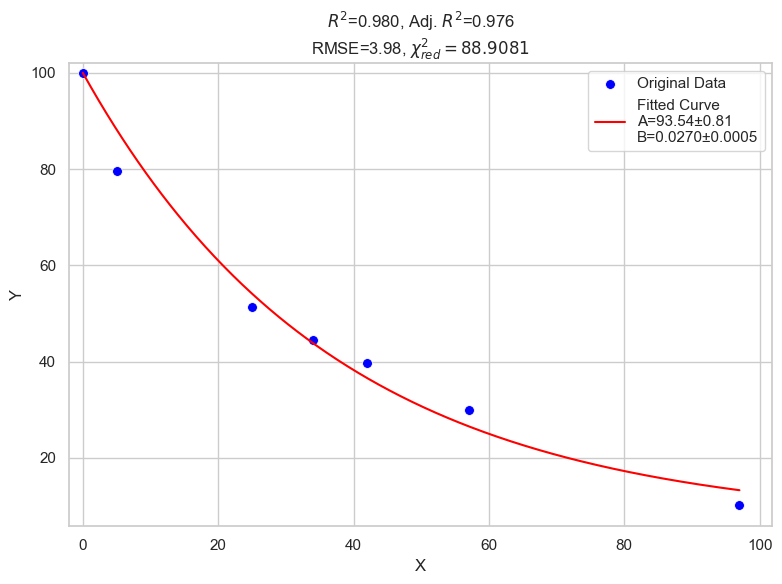

In [54]:
plt.figure(figsize=(8, 6))
sns.set_theme(style="whitegrid") # Sets a grid style similar to plt.grid(True)

sns.scatterplot(x=results["x_data"], y=results["y_data"], label="Original Data", color='blue', s=50)

x_plot = np.linspace(min(results["x_data"]), max(results["x_data"]), 500)
y_plot = custom_function(x_plot, results["fit_a"], results["fit_b"])
sns.lineplot(x=x_plot, y=y_plot, color='red', label=f"Fitted Curve\nA={results['fit_a']:.2f}±{results['std_err_a']:.2f}\nB={results['fit_b']:.4f}±{results['std_err_b']:.4f}")

plt.title(f"$R^2$={results['r_squared_weighted']:.3f}, Adj. $R^2$={results['r_squared_adj_weighted']:.3f}\nRMSE={results['rmse_weighted']:.2f}, $\\chi^2_{{red}}={results['reduced_chi_squared']:.4f}$")

plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.xlim(xmin=-2)
plt.ylim(ymax=102)

plt.tight_layout()
plt.show()


### Analysis of the results

The results are totally the same as in the previous case.

It's clear that for dataset 1 and dataset 2 the results of our analysis show that the selected function doesn't fit the data well enough:
* RMSE is too high
* $\chi^2_{red}$ is too high

Thus, we need to look for another custom function for the datasets 1 and 2.

For the dataset 3:

* **Reduced Chi-Squared ($\chi^2_{red}$):** This is a measure of the **goodness-of-fit relative to our assumed measurement errors**. It normalizes the residuals by the standard deviation of the measurements ($\sigma_i$). A value close to 1 means the observed scatter of our data points around the fit is consistent with our assumed uncertainties.
    * Since $\chi^2_{red}$ is 1.4472 (greater than 1), it suggests that the scatter in our data is **larger than what we expected** based on our assumed standard deviation of 0.5. This implies that we have likely **underestimated the true measurement uncertainty**.

* **Root Mean Squared Error (RMSE):** This is an **estimate of the standard deviation of the residuals**. The fact that our RMSE (0.5084) is very close to our assumed $\sigma_i$ of 0.5 is a common occurrence and shows that our model is fitting the data well. However, because the reduced chi-squared is greater than 1, it tells us that the true underlying noise in the data is likely a bit larger than 0.5, even if the RMSE is close to that value. The $\chi^2_{red}$ is a more robust statistical tool for validating our assumption about the uncertainty of our measurements.

Let's try to increase the standard deviations from 0.5 to 1.0.

### Usage of the Higher Value of Errors

Results for the dataset 1 and 2:
* RMSE is too high
* $\chi^2_{red}$ is too high

Results for the dataset 3:
* A reduced chi-squared value of 0.3618 is too low and indicates that we have overestimated the standard deviation of our measurements.
* Also, note that the errors for A and B parameters were increased afrer we increased

The standard deviation of 0.6 will make $\chi^2_{red}$ very close to 1 for the dataset 3 (see below)

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns
import scipy.stats as stats

In [56]:
def custom_function(x, A, B):
    """
    The custom function to approximate the data.
    f(x; A, B) = A * (np.exp(-B * x) - 1) + 100
    """
    return A * (np.exp(-B * x) - 1) + 100

In [57]:
def analyze_curve_fit(x, y_obs, sigma, function, initial_guess):
    """
    Performs a weighted least squares curve fit and calculates various
    goodness-of-fit and error metrics.

    Args:
        x (np.array): The independent variable data.
        y_obs (np.array): The observed dependent variable data.
        sigma (np.array): The standard deviations of the y_obs points.
        function (callable): The function to fit to the data.
        initial_guess (list): The initial guess for the function parameters.

    Returns:
        dict: A dictionary containing all the calculated results.
    """
    results = {}

    results['x_data'] = x
    results['y_data'] = y_obs
    results['sigma'] = sigma
    results['weights'] = 1.0 / (sigma**2)

    # Perform the curve fit
    popt, pcov, infodict, _, _ = curve_fit(
        function, x, y_obs, p0=initial_guess, sigma=sigma,
        absolute_sigma=True, full_output=True
    )

    results['popt'] = popt
    results['pcov'] = pcov

    # Calculate standard errors and t/p-values
    perr = np.sqrt(np.diag(pcov))
    n = len(x)
    p = len(popt)
    degrees_of_freedom = n - p

    t_values = popt / perr
    p_values = stats.t.sf(np.abs(t_values), df=degrees_of_freedom) * 2

    results['fit_params'] = popt
    results['std_errs'] = perr
    results['t_values'] = t_values
    results['p_values'] = p_values
    results['number_of_observations'] = n
    results['number_of_parameters'] = p
    results['degrees_of_freedom'] = degrees_of_freedom
    results['condition_number'] = np.linalg.cond(pcov)

    # Generate predicted values and residuals
    y_pred = function(x, *popt)
    residuals_calc = y_obs - y_pred
    weighted_residuals = (y_obs - y_pred) / sigma
    
    results['y_pred'] = y_pred
    results['residuals_calc'] = residuals_calc
    results['weighted_residuals'] = weighted_residuals
    results['residuals_scipy'] = infodict['fvec']

    # --- Sum of Squares (SS) Calculations ---
    rss_unweighted = np.sum(residuals_calc**2)
    rss_weighted = np.sum(weighted_residuals**2)

    weighted_mean_y = np.sum(results['weights'] * y_obs) / np.sum(results['weights'])
    unweighted_mean_y = np.mean(y_obs)

    weighted_centered_tss = np.sum(results['weights'] * (y_obs - weighted_mean_y)**2)
    unweighted_centered_tss = np.sum((y_obs - unweighted_mean_y)**2)

    ess_weighted = np.sum(results['weights'] * (y_pred - weighted_mean_y)**2)
    ess_unweighted = np.sum((y_pred - unweighted_mean_y)**2)

    results['rss_unweighted'] = rss_unweighted
    results['rss_weighted'] = rss_weighted
    results['unweighted_centered_tss'] = unweighted_centered_tss
    results['weighted_centered_tss'] = weighted_centered_tss
    results['ess_unweighted'] = ess_unweighted
    results['ess_weighted'] = ess_weighted

    # --- Goodness-of-Fit Metrics ---
    # R-squared
    r_squared_unweighted = 1 - rss_unweighted / unweighted_centered_tss
    r_squared_weighted = 1 - rss_weighted / weighted_centered_tss

    # Adjusted R-squared
    r_squared_adj_unweighted = 1 - (1 - r_squared_unweighted) * ((n - 1) / (n - p))
    r_squared_adj_weighted = 1 - (1 - r_squared_weighted) * ((n - 1) / (n - p))

    # Chi-Squared and Reduced Chi-Squared
    chi_squared = rss_weighted
    reduced_chi_squared = chi_squared / degrees_of_freedom

    results['r_squared_unweighted'] = r_squared_unweighted
    results['r_squared_weighted'] = r_squared_weighted
    results['r_squared_adj_unweighted'] = r_squared_adj_unweighted
    results['r_squared_adj_weighted'] = r_squared_adj_weighted
    results['chi_squared'] = chi_squared
    results['reduced_chi_squared'] = reduced_chi_squared

    # --- Error Metrics ---
    # RMSE
    rmse_unweighted = np.sqrt(rss_unweighted / n)
    rmse_weighted = np.sqrt(rss_weighted / np.sum(results['weights']))

    # SER (Standard Error of the Regression)
    ser_unweighted = np.sqrt(rss_unweighted / degrees_of_freedom)
    ser_weighted = np.sqrt(rss_weighted / degrees_of_freedom)

    results['rmse_unweighted'] = rmse_unweighted
    results['rmse_weighted'] = rmse_weighted
    results['ser_unweighted'] = ser_unweighted
    results['ser_weighted'] = ser_weighted

    # --- Log-Likelihood and Information Criteria ---
    mle_variance = rss_weighted / n
    llf = -n/2 * np.log(2*np.pi * mle_variance) - rss_weighted/(2*mle_variance)
    aic = -2 * llf + 2 * p
    bic = -2 * llf + np.log(n) * p
    aicc = aic + (2 * p * (p + 1)) / (n - p - 1)

    results['log_likelihood'] = llf
    results['aic'] = aic
    results['bic'] = bic
    results['aicc'] = aicc

    return results

In [58]:
def print_metrics(results):
    """
    Prints the calculated metrics from the results dictionary.
    
    Args:
        results (dict): The dictionary containing curve fit results.
    """
    fit_params = results['fit_params']
    std_errs = results['std_errs']
    t_values = results['t_values']
    p_values = results['p_values']
    n = results['number_of_observations']
    p = results['number_of_parameters']

    print("--- Fitted Parameters ---")
    for i, (param, err) in enumerate(zip(fit_params, std_errs)):
        print(f"Parameter {chr(ord('A') + i)}: {param:.4f} +/- {err:.4f}")
        print(f"  T-value: {t_values[i]:.6f}, P-value: {p_values[i]:.6f}")

    print(f"\nNumber of Observations (n): {n}")
    print(f"Number of Parameters (p): {p}")
    print(f"Degrees of Freedom (n-p): {results['degrees_of_freedom']}")

    print("\n--- Goodness-of-Fit & Error Metrics ---")
    print(f"Weighted R-squared: {results['r_squared_weighted']:.4f}")
    print(f"Unweighted R-squared: {results['r_squared_unweighted']:.4f}")
    print(f"Weighted Adjusted R-squared: {results['r_squared_adj_weighted']:.4f}")
    print(f"Unweighted Adjusted R-squared: {results['r_squared_adj_unweighted']:.4f}")
    print(f"Chi-Squared: {results['chi_squared']:.4f}")
    print(f"Reduced Chi-Squared ($\chi^2_{{red}}$): {results['reduced_chi_squared']:.4f}")
    print(f"Unweighted RMSE: {results['rmse_unweighted']:.4f}")
    print(f"Weighted RMSE: {results['rmse_weighted']:.4f}")
    print(f"Unweighted SER: {results['ser_unweighted']:.4f}")
    print(f"Weighted SER: {results['ser_weighted']:.4f}")

    print("\n--- Information Criteria ---")
    print(f"Log-Likelihood: {results['log_likelihood']:.4f}")
    print(f"AIC: {results['aic']:.4f}")
    print(f"BIC: {results['bic']:.4f}")
    print(f"AICc: {results['aicc']:.4f}")

<>:30: SyntaxWarning: invalid escape sequence '\c'
<>:30: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Vladyslav\AppData\Local\Temp\ipykernel_3488\2445946772.py:30: SyntaxWarning: invalid escape sequence '\c'
  print(f"Reduced Chi-Squared ($\chi^2_{{red}}$): {results['reduced_chi_squared']:.4f}")


In [59]:
def draw_curve_fit(results):
    """
    Visualizes the original data and the fitted curve.
    
    Args:
        results (dict): The dictionary containing curve fit results.
    """
    plt.figure(figsize=(8, 6))
    sns.set_theme(style="whitegrid")

    x_data = results["x_data"]
    y_data = results["y_data"]
    popt = results['fit_params']
    perr = results['std_errs']
    
    sns.scatterplot(x=x_data, y=y_data, label="Original Data", color='blue', s=50)

    # Generate points for the fitted curve
    x_plot = np.linspace(min(x_data), max(x_data) * 1.05, 500)
    y_plot = custom_function(x_plot, *popt)
    
    label_text = f"Fitted Curve\n"
    for i, (param, err) in enumerate(zip(popt, perr)):
        label_text += f"{chr(ord('A') + i)}={param:.2f}±{err:.2f} "

    sns.lineplot(x=x_plot, y=y_plot, color='red', label=label_text.strip())

    plt.title(f"$R^2$={results['r_squared_weighted']:.3f}, Adj. $R^2$={results['r_squared_adj_weighted']:.3f}\nRMSE={results['rmse_weighted']:.2f}, $\\chi^2_{{red}}={results['reduced_chi_squared']:.4f}$")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)
    plt.xlim(xmin=min(x_data) - 5)
    plt.ylim(ymin=min(y_data) - 10, ymax=max(y_data) + 10)
    plt.tight_layout()
    plt.show()

--- Fitted Parameters ---
Parameter A: 93.5355 +/- 0.8080
  T-value: 115.759755, P-value: 0.000000
Parameter B: 0.0270 +/- 0.0005
  T-value: 53.507498, P-value: 0.000000

Number of Observations (n): 7
Number of Parameters (p): 2
Degrees of Freedom (n-p): 5

--- Goodness-of-Fit & Error Metrics ---
Weighted R-squared: 0.9798
Unweighted R-squared: 0.9798
Weighted Adjusted R-squared: 0.9757
Unweighted Adjusted R-squared: 0.9757
Chi-Squared: 444.5407
Reduced Chi-Squared ($\chi^2_{red}$): 88.9081
Unweighted RMSE: 3.9845
Weighted RMSE: 3.9845
Unweighted SER: 4.7146
Weighted SER: 9.4291

--- Information Criteria ---
Log-Likelihood: -24.4615
AIC: 52.9231
BIC: 52.8149
AICc: 55.9231


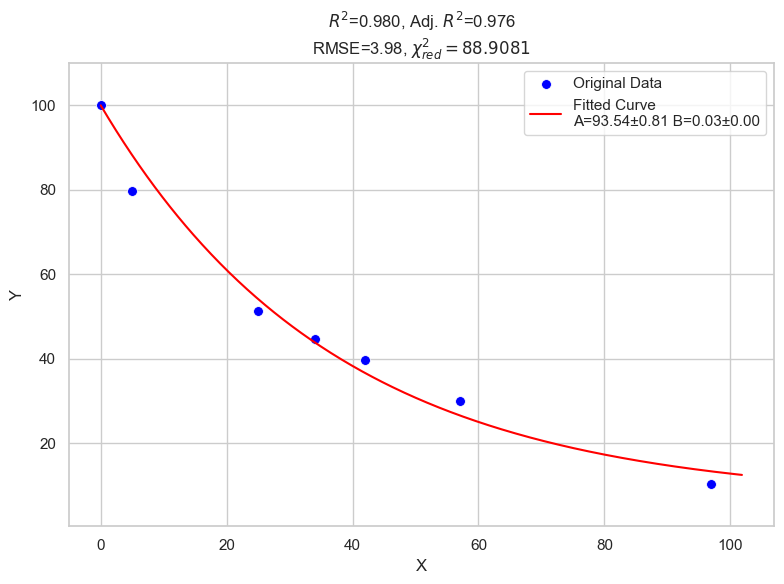

In [60]:
# Define the data and parameters for analysis
x = np.array([0, 5, 25, 34, 42, 57, 97])
y_obs = np.array([100, 79.7, 51.3, 44.6, 39.8, 29.9, 10.3])
sigma = np.full_like(y_obs, 0.5, dtype=float)
initial_guess = [50, 0.01]

# Analyze the curve fit and get results
fit_results = analyze_curve_fit(x, y_obs, sigma, custom_function, initial_guess)

# Print the metrics
print_metrics(fit_results)

# Draw the curve fit plot
draw_curve_fit(fit_results)